In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_processor_pipeline.cleaner import *
from data_processor_pipeline.custom_dataset import *
from datasets import load_dataset
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

# Data_Preprocess

## Read data and cleaning

In [2]:
data=pd.read_csv('vietnamese_student_feedbacks.csv', encoding='utf-8-sig')
data_processor=data_clean()
data['sentence']=data['sentence'].map(lambda x: data_processor.clean_text(x))

## Train_validation_test

In [3]:
from sklearn.model_selection import train_test_split

data['combined_label']=list(zip(data["sentiment"], data['topic']))
X_train, X_test, y_train, y_test = train_test_split(data['sentence'].reset_index(drop=True).to_list(),
                                                    data['combined_label'].reset_index(drop=True).to_list(),
                                                    test_size=0.1,
                                                    stratify=data['topic'],
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [4]:
len(X_train), len(X_val), len(X_test)

(13101, 1456, 1618)

In [5]:
y_train_sentiment, y_train_topic = zip(*y_train)
y_val_sentiment, y_val_topic = zip(*y_val)
y_test_sentiment, y_test_topic = zip(*y_test)

## Resampled

In [6]:
df_y_train_sentiment = pd.DataFrame(y_train_sentiment, columns=['y_train_sentiment'])

In [6]:
from sklearn.utils import resample

# Separate neutral comments
neutral_indices = df_y_train_sentiment[df_y_train_sentiment['y_train_sentiment']==1].to_numpy().flatten()
oversample_size = df_y_train_sentiment[df_y_train_sentiment['y_train_sentiment']==0].shape[0] - len(neutral_indices)

# Over-sample the neutral comments
oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

# Combine the original sentences and labels with the oversampled data
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([y_train_sentiment, np.array([1] * oversample_size)], axis=0)

In [7]:
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = pd.Series(train_labels_oversampled)

## Create dataLoader

## Sentiment

In [6]:
train_dataset_sentiment=Custom_Dataset(X_train, y_train_sentiment, file_path='vocab.pkl', is_save_vocab=False)
val_dataset_sentiment=Custom_Dataset(X_val, y_val_sentiment, file_path='vocab.pkl', is_save_vocab=False)
test_dataset_sentiment=Custom_Dataset(X_test, y_test_sentiment, file_path='vocab.pkl', is_save_vocab=False)

In [7]:
train_loader_sentiment=DataLoader(train_dataset_sentiment, batch_size=16, shuffle=True)
val_loader_sentiment=DataLoader(val_dataset_sentiment, batch_size=16, shuffle=True)
test_loader_sentiment=DataLoader(test_dataset_sentiment, batch_size=16, shuffle=True)

# DL_model for sentiment classification

In [8]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate(model, test_loader, device):
    model.eval()
    predicted=[]
    true_labels=[]
    with torch.no_grad():
        for batch in test_loader:
            output_logits=model(batch['numericalized_encode'].to(device))
            _, predict=torch.max(output_logits, 1)
            predicted.extend(predict.cpu().numpy())
            true_labels.extend(batch['labels'].to(device).cpu().numpy())
    return predicted, true_labels

## RNN

### Training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from build_model.build_rnn import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_RNN=RNN(vocab_size=5000, embedding_dim=128, activation=nn.ReLU(), batch_normalization=True, bidirectional=False).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_RNN=optim.Adam(model_RNN.parameters(), lr=0.01)
epochs=5
trainer=trainer()
log_dir='logs/RNN'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer=SummaryWriter(log_dir='logs/RNN')
print(model_RNN)

RNN(
  (embedding): Embedding(5000, 128)
  (rnn): RNN(128, 64, num_layers=2, dropout=0.2)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=3, bias=True)
)


In [10]:
best_Acc_RNN=0
for epoch in range(epochs):
    trainer.train(model_RNN, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_RNN, device)
    val_loss, val_acc = trainer.validation(model_RNN, val_loader_sentiment, criterion, device)
    print(f"VALIDATION | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_RNN.state_dict(),
        'epoch': epoch+1,
        'optimizer_state_dict': optimizer_RNN.state_dict()
    }
    os.makedirs('model/RNN', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/RNN', 'last.pt'))
    if val_acc>best_Acc_RNN:
        torch.save(checkpoint, os.path.join('model/RNN', 'best.pt'))
        best_Acc_RNN=val_acc

TRAIN | Epoch: 1/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0529: 100%|███████████████| 819/819 [00:31<00:00, 25.98it/s]


VALIDATION | Epoch: 1/5 | Loss: 0.0514 | Accuracy: 0.5364


TRAIN | Epoch: 2/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0520: 100%|███████████████| 819/819 [00:31<00:00, 26.32it/s]


VALIDATION | Epoch: 2/5 | Loss: 0.0514 | Accuracy: 0.5357


TRAIN | Epoch: 3/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0517: 100%|███████████████| 819/819 [00:31<00:00, 26.10it/s]


VALIDATION | Epoch: 3/5 | Loss: 0.0520 | Accuracy: 0.5350


TRAIN | Epoch: 4/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0516: 100%|███████████████| 819/819 [00:31<00:00, 25.77it/s]


VALIDATION | Epoch: 4/5 | Loss: 0.0515 | Accuracy: 0.5350


TRAIN | Epoch: 5/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0515: 100%|███████████████| 819/819 [00:31<00:00, 25.89it/s]


VALIDATION | Epoch: 5/5 | Loss: 0.0516 | Accuracy: 0.5371


## GRU

### Training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from build_model.build_gru import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GRU=GRU(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=False).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_GRU=optim.Adam(model_GRU.parameters(), lr=0.001)
epochs=5
trainer=trainer()
log_dir='logs/GRU'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir=log_dir)
print(model_GRU)

GRU(
  (embedding): Embedding(5000, 128)
  (gru): GRU(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=3, bias=True)
)


In [51]:
best_acc=0
for epoch in range(epochs):
    trainer.train(model_GRU, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_GRU, device)
    val_loss, val_acc = trainer.validation(model_GRU, val_loader_sentiment, criterion, device)
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_GRU.state_dict(),
        'epoch': epoch+1,
        'opimizer_state_dict': optimizer.state_dict(),
    }
    os.makedirs('model/GRU', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/GRU','last.pt'))
    if val_acc>best_acc:
        torch.save(checkpoint, os.path.join('model/GRU','best.pt'))
        best_acc=val_acc

TRAIN | Epoch: 1/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0323: 100%|███████████████| 819/819 [00:42<00:00, 19.17it/s]


TEST | Epoch: 1/5 | Loss: 0.0221 | Accuracy: 0.8874


TRAIN | Epoch: 2/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0192: 100%|███████████████| 819/819 [00:46<00:00, 17.44it/s]


TEST | Epoch: 2/5 | Loss: 0.0163 | Accuracy: 0.9203


TRAIN | Epoch: 3/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0152: 100%|███████████████| 819/819 [00:45<00:00, 17.96it/s]


TEST | Epoch: 3/5 | Loss: 0.0157 | Accuracy: 0.9217


TRAIN | Epoch: 4/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0121: 100%|███████████████| 819/819 [00:47<00:00, 17.22it/s]


TEST | Epoch: 4/5 | Loss: 0.0170 | Accuracy: 0.9183


TRAIN | Epoch: 5/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0097: 100%|███████████████| 819/819 [00:46<00:00, 17.79it/s]


TEST | Epoch: 5/5 | Loss: 0.0197 | Accuracy: 0.9196


### Evaluate


In [12]:
model_state_dict=torch.load('model/GRU/best.pt', map_location=device)
model_GRU.load_state_dict(model_state_dict['model_state_dict'])
test_loss, test_acc = trainer.validation(model_GRU, test_loader_sentiment, criterion, device)
test_acc

0.9122373300370828

In [15]:
pred, true=evaluate(model_GRU, test_loader_sentiment, device)

In [17]:
report = classification_report(pred, true, output_dict=True)

In [19]:
report_df=pd.DataFrame(report).transpose().reset_index()

In [25]:
report_df

,index,precision,recall,f1-score,support
0,0,0.938420,0.910390,0.924192,770.000000
1,1,0.361111,0.590909,0.448276,44.000000
2,2,0.937422,0.931592,0.934498,804.000000
3,accuracy,0.912237,0.912237,0.912237,0.912237
4,macro avg,0.745651,0.810964,0.768989,1618.000000
5,weighted avg,0.922225,0.912237,0.916371,1618.000000


In [26]:
model_eval=report_df[report_df['index']=='weighted avg'][['precision','recall', 'f1-score']]

In [29]:
model_eval['accuracy']=accuracy_score(pred, true)

In [32]:
model_eval.reset_index(drop=True)

,precision,recall,f1-score,accuracy
0,0.922225,0.912237,0.916371,0.912237


In [33]:
confusion_matrix(true, pred)

array([[701,  12,  34],
       [ 25,  26,  21],
       [ 44,   6, 749]], dtype=int64)

In [13]:
result=trainer.evaluate(model_GRU, test_loader_sentiment, device)

{'accuracy': 0.9122373300370828,
 'precision': 0.9222247625342096,
 'recall': 0.9122373300370828,
 'f1-score': 0.9163711965710459,
 'confusion_matrix': array([[701,  12,  34],
        [ 25,  26,  21],
        [ 44,   6, 749]], dtype=int64)}

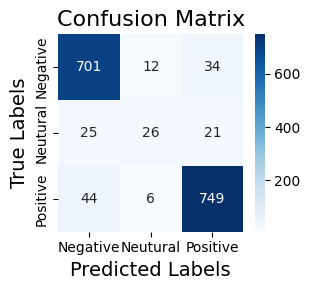

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ma trận nhầm lẫn
cm = np.array([[701, 12, 34],
               [25, 26, 21],
               [44, 6, 749]])

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(3.2, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True)

# Thêm tiêu đề và nhãn
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Negative', 'Neutural', 'Positive'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Negative', 'Neutural', 'Positive'])

# Hiển thị đồ thị
plt.tight_layout()
plt.show()
